# House Prices Challenge
## The scenario
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

## Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

# 1. Load the houseprices data from Thinkful's database.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings("ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

House Prices data is now in `df`. Quick look...

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# 2. Do data cleaning, exploratory data analysis, and feature engineering.

## Data Cleaning

The `id` column can be dropped.

In [4]:
df.drop(columns='id', inplace=True)

A large amount of variables should be categorical datatypes (mostly needed for later, as outliers shouldn't be found in this particular categorical data).

In [5]:
cat_list = ['mssubclass','mszoning','street','alley','lotshape','landcontour','utilities','lotconfig','landslope','neighborhood','condition1','condition2',
            'bldgtype','housestyle','roofstyle','roofmatl','exterior1st','exterior2nd','masvnrtype','exterqual','extercond','foundation','bsmtqual','bsmtcond',
            'bsmtexposure','bsmtfintype1','bsmtfintype2','heating','heatingqc','centralair','electrical','kitchenqual','functional','fireplacequ','garagetype',
            'garagefinish','garagequal','garagecond','paveddrive','poolqc','fence','miscfeature','saletype','salecondition', 'overallqual', 'overallcond', 
            'yearbuilt', 'yearremodadd', 'mosold', 'yrsold', 'bedroomabvgr']
for var in cat_list:
    df[var] = df[var].astype('category')

A function is defined in order to fill null values (most of which are a subset of the above categorical list). This particular function takes null values and fills them with the category 'None' instead. The reasoning behind this is actually from the documentation on the dataset as many of the NA/null/None values are actually intended to indicate the lack of a particular feature/quality of a house rather than missing data.

In [6]:
def add_cat_fillna(variable, new_cat='None'):
    df[variable] = df[variable].cat.add_categories(new_cat).fillna(new_cat).copy()

Below, a list of columns with nulls defined as the lack of a feature/quality of a house is created then the above function is called for all variables in that list.

In [7]:
nulls_list = ['alley','bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2','fireplacequ','garagetype','garagefinish','garagequal','garagecond',
             'poolqc','fence','miscfeature']
for var in nulls_list:
    add_cat_fillna(var)

The variables below were special cases where a few different methods were used to fill null values.
1. `masvnrtype` already contained a 'None' category and thus the nulls could just be added to that
2. `masvnrarea` should be zero for any rows where `masvnrtype` is 'None' which was the case for all rows here
3. `lotfrontage` took the median value as the variance in the data was relatively significant
4. `electrical` only had one missing value, since it is a category it was filled with the most common category
5. `garageyrblt` is dropped from the dataset as it contains a large amount of null values and `garagetype` was more explanatory of the outcome variable;| because of that, I valued the variability in the rows over the information added by the `garageyrblt` variable

In [8]:
df.masvnrtype = df.masvnrtype.fillna('None').copy()
df.masvnrarea = df.masvnrarea.fillna(0).copy()
df.lotfrontage = df.lotfrontage.fillna(df.lotfrontage.median()).copy()
df.electrical = df.electrical.fillna(df.electrical.mode()[0]).copy()
df.drop(columns='garageyrblt', inplace=True)

A function is defined below that returns a list of indexes where outliers are found with a default threshold of 2 standard deviations from the mean.

In [9]:
def outliers_std(data, columns, thresh=2):
    outlier_indexes = []
    for col in columns:
        ser_col = data[col]
        mean = ser_col.mean()
        sd = ser_col.std()
        outliers_mask = data[(data[col] > mean + thresh*sd) | (data[col] < mean - thresh*sd)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

The above function is called and rows with extreme values are eliminated from the dataset.

In [10]:
df.drop(outliers_std(df, df.describe().columns), inplace=True)

After dropping all the outliers, there are some variables with zero variability and they won't help at all with making predictions with linear regression.

In [11]:
for col in df.describe().columns:
    if df[col].std() == 0:
        df.drop(columns=col, inplace=True)

*Note on Data Cleaning Section: The above is a summarized walkthrough of the data cleaning thought process and decision making process which can be viewed in full here: [Original House Prices Analysis](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/house_prices_assignment.ipynb).*

## Data Exploration

### Univariate Analysis

#### Continuous:

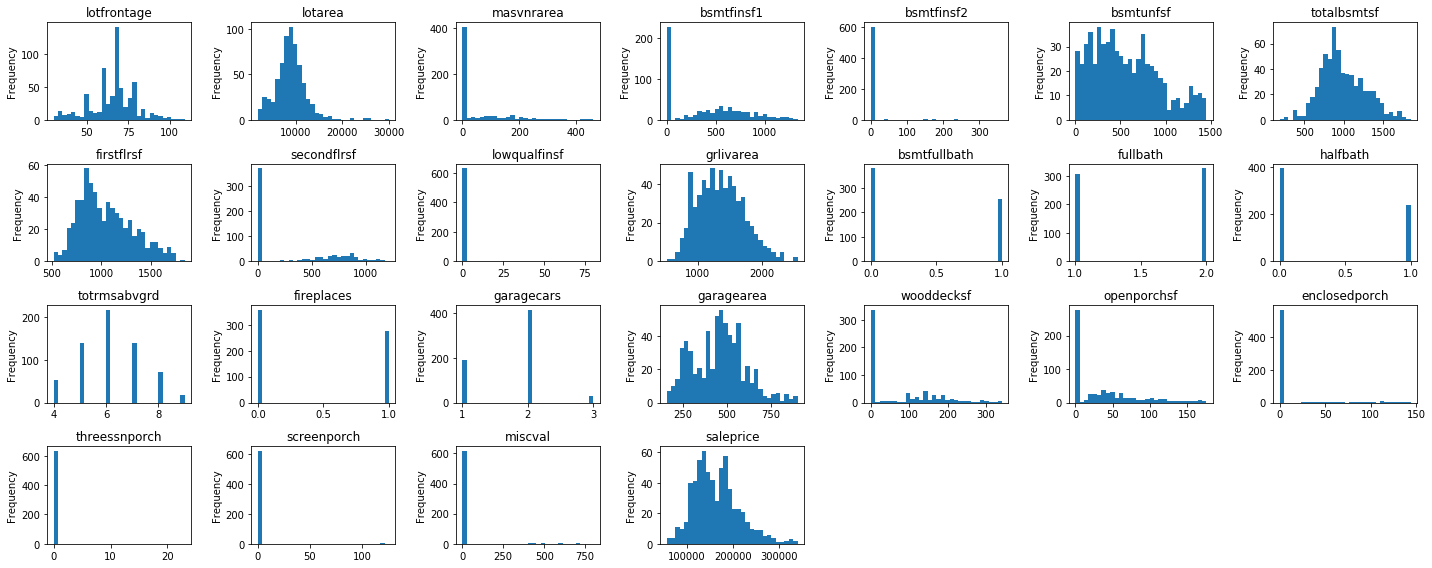

In [12]:
plt.figure(figsize=(20, 8))
for i, col in enumerate(df.describe().columns, 1):
    plt.subplot(4, 7, i)
    df[col].plot(kind='hist', bins=30)
    plt.title(str(col))
plt.tight_layout()
plt.show()

#### Categorical:

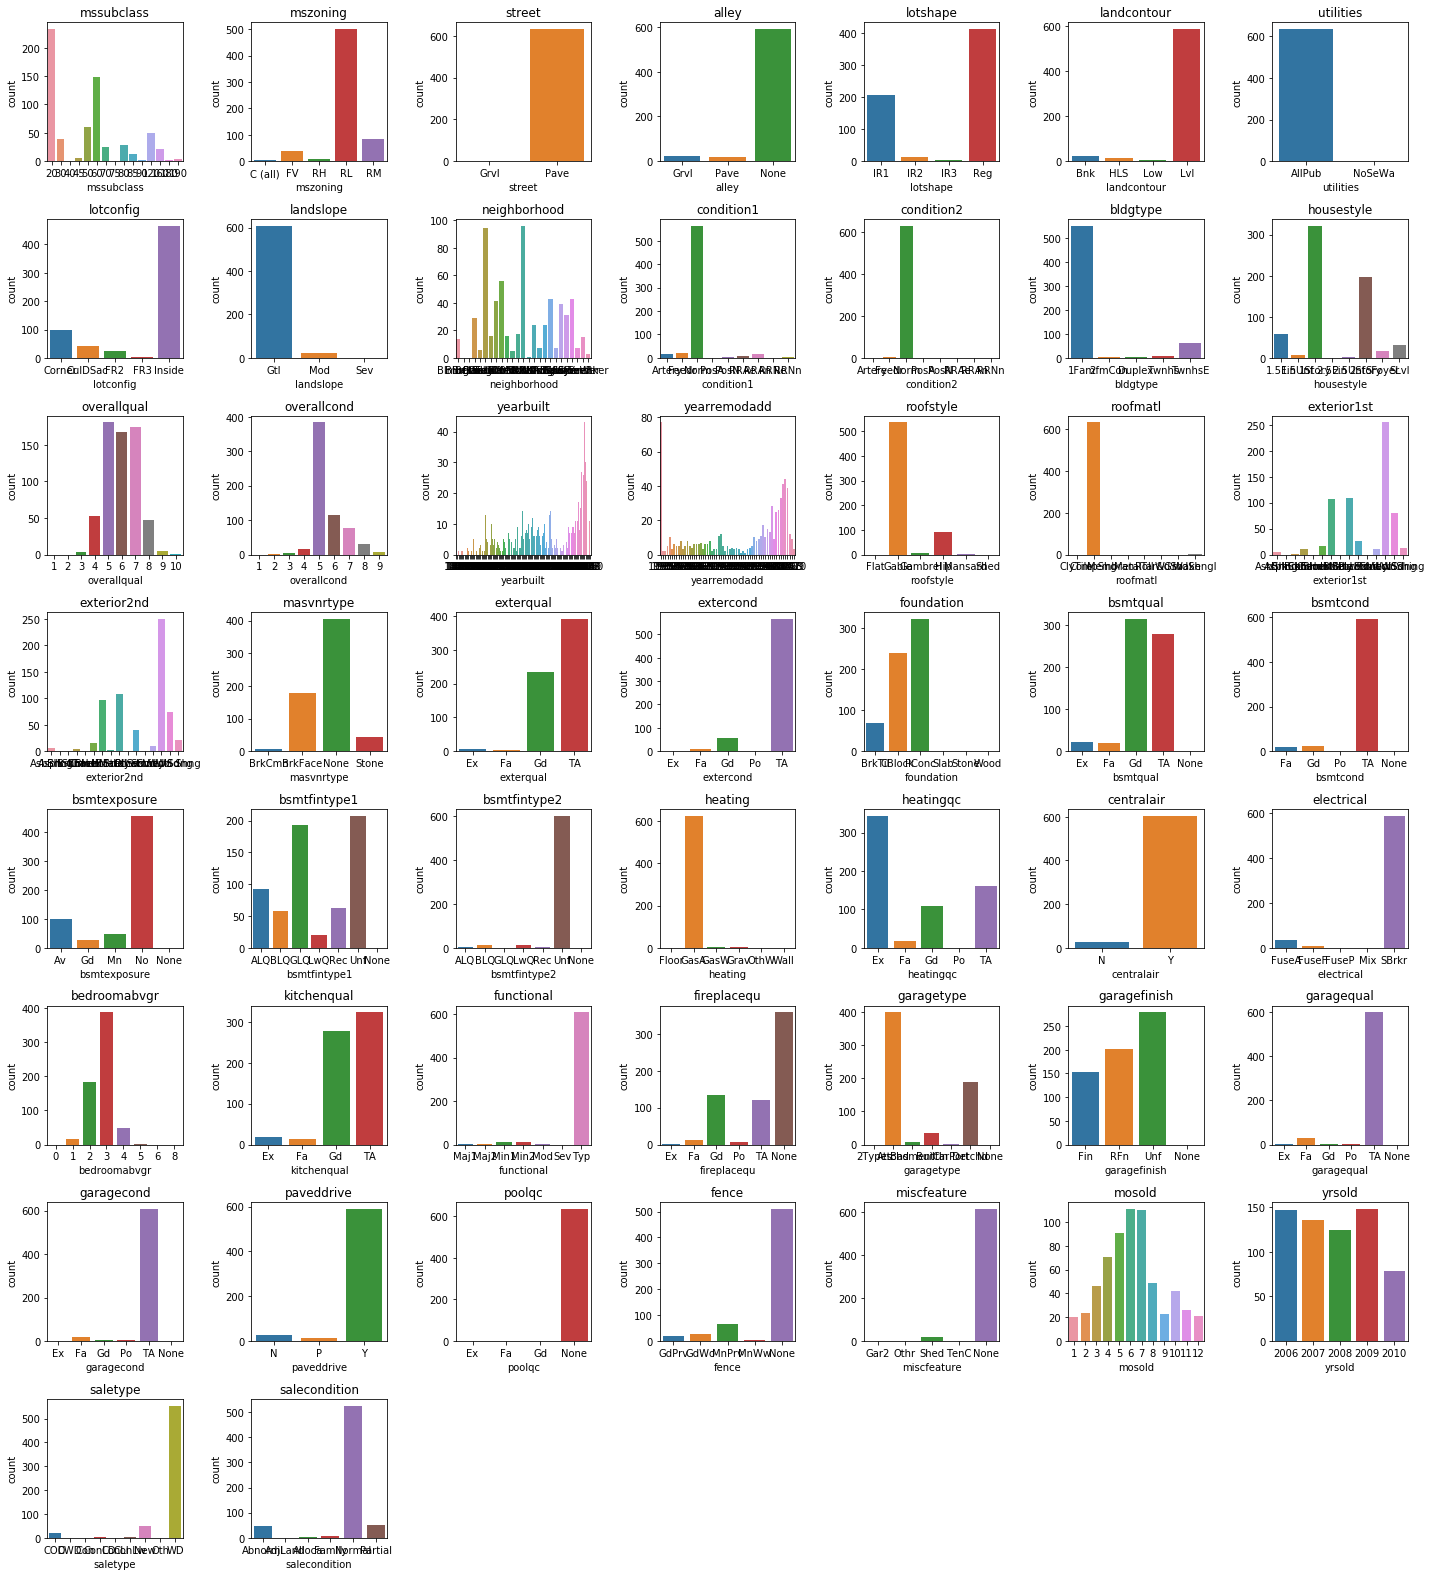

In [13]:
plt.figure(figsize=(20, 22))
for i, col in enumerate(df.describe(include='category').columns, 1):
    plt.subplot(8, 7, i)
    sns.countplot(x=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()

### Bivariate Analysis

#### Continuous - Continuous:

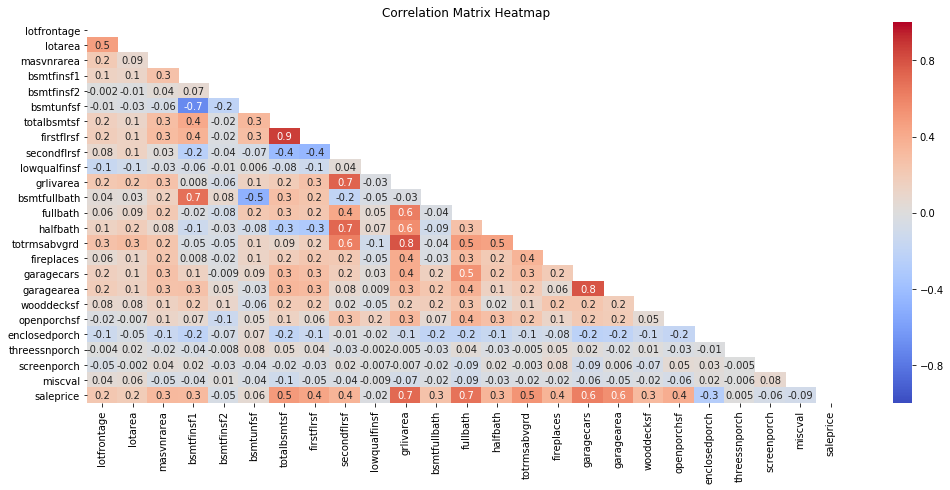

In [14]:
mask = np.triu(df.corr())
plt.figure(figsize=(17,7))
sns.heatmap(df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(df.corr().shape[1], 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Continuous with respect to House Price (Target):

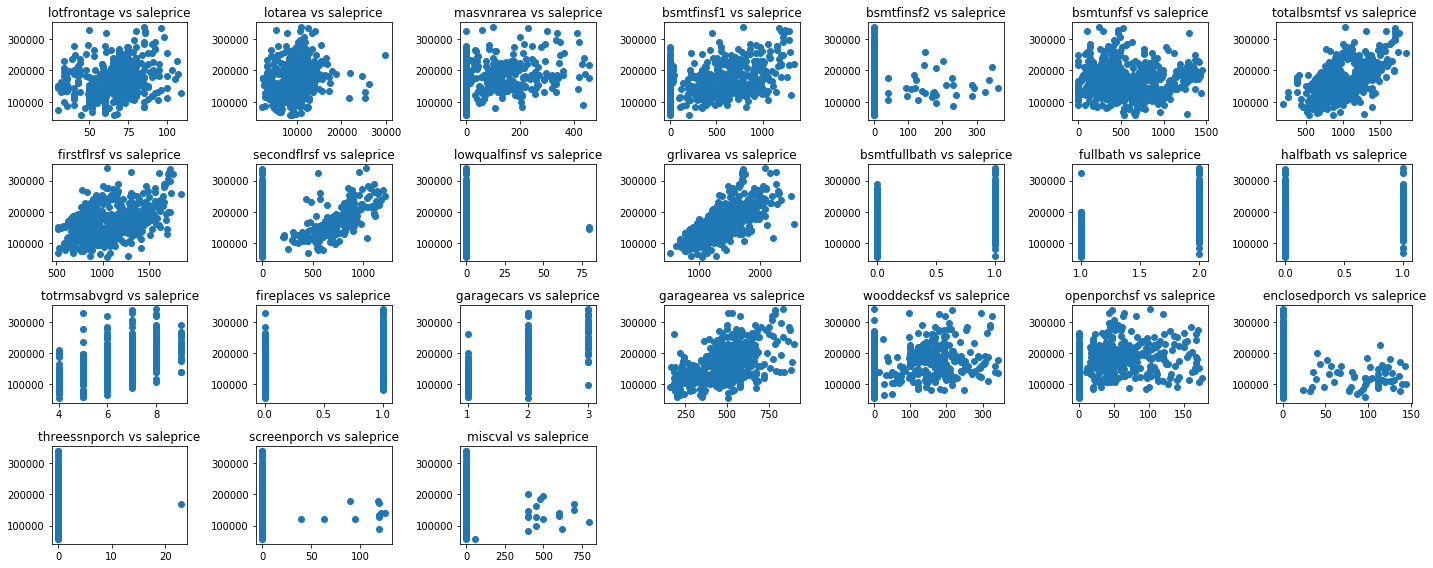

In [15]:
plt.figure(figsize=(20, 8))
for i, col in enumerate(df.describe().columns[:-1], 1):
    plt.subplot(4, 7, i)
    plt.scatter(x=df[col], y=df.saleprice)
    plt.title('{} vs saleprice'.format(col))
plt.tight_layout()
plt.show()

#### Categorical with respect to House Price (Target):

In [16]:
highlights = ['mssubclass', 'mszoning', 'housestyle', 'overallqual', 'exterqual', 'bsmtqual', 'kitchenqual', 'bedroomabvgr']

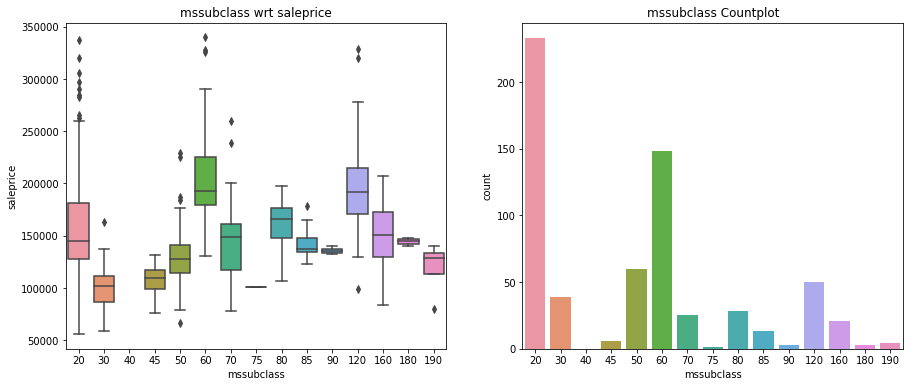

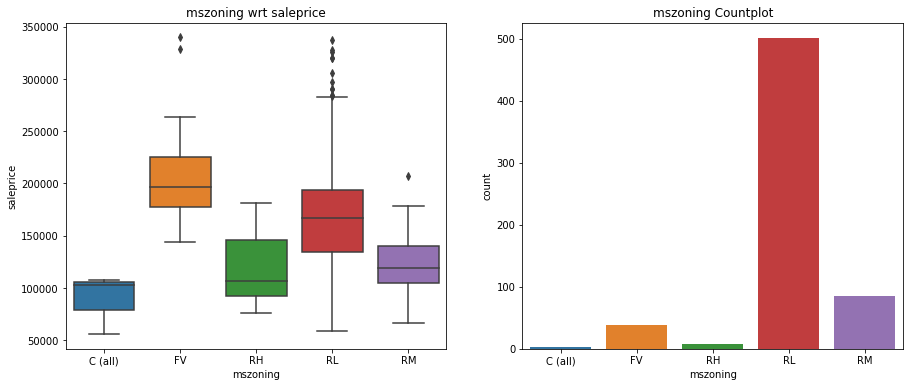

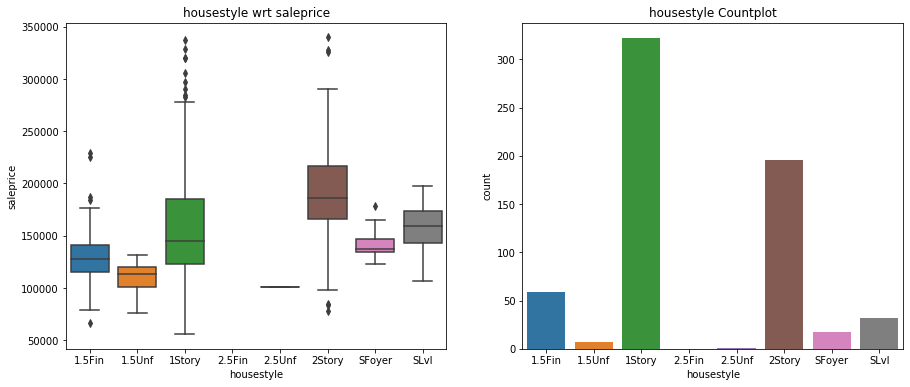

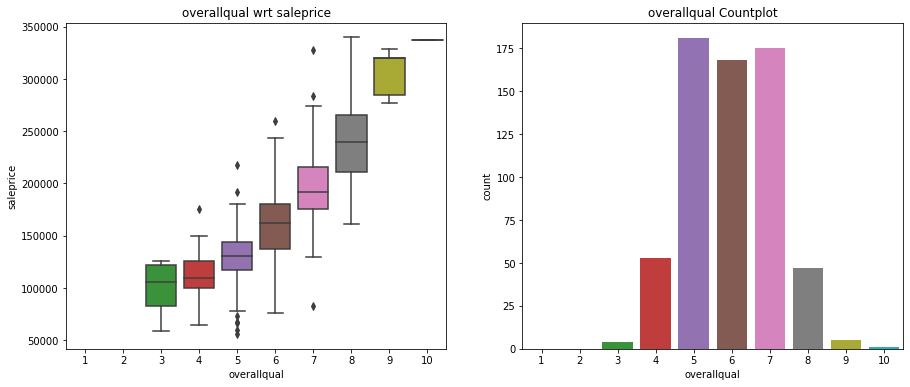

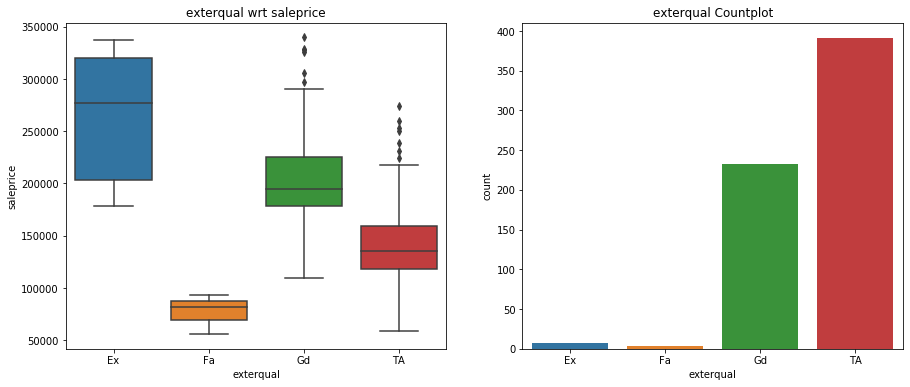

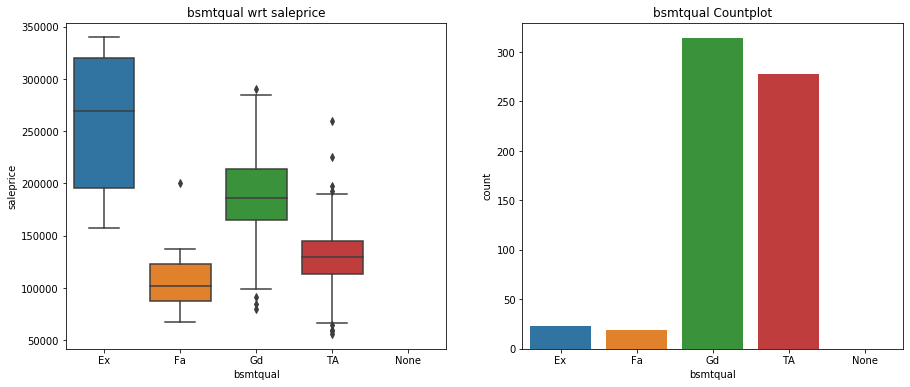

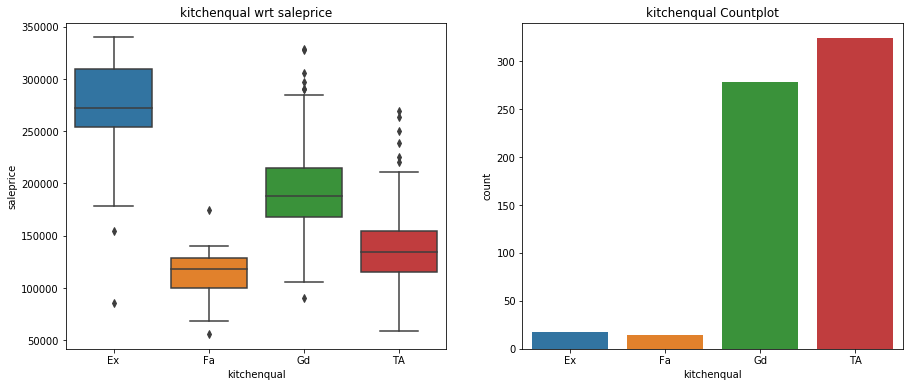

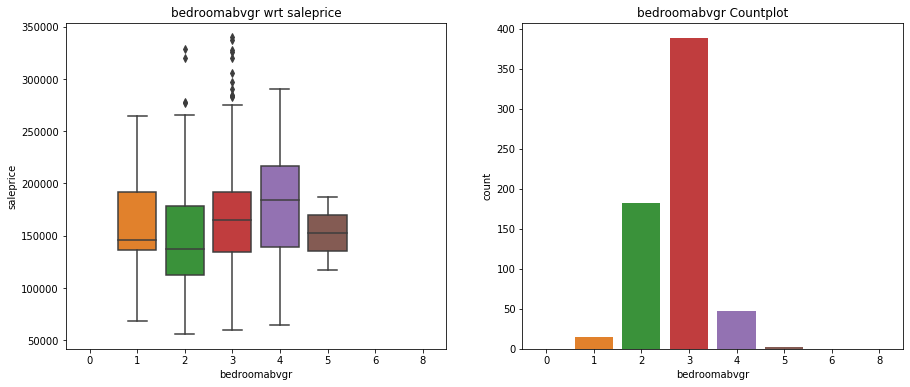

In [17]:
for col in highlights:
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    sns.boxplot(x=col, y='saleprice', data=df)
    plt.title('{} wrt saleprice'.format(col))
    plt.subplot(122)
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Countplot')
    plt.show()

*Note on the Categorical with respect to House Prices section: The above is only an excerpt of significant highlights from the more in depth, variable by variable, analysis which can be viewed here: [Original House Prices Analysis](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/house_prices_assignment.ipynb).*

## Feature Engineering

There are a number of continuous variables and combinations of continuous variables that can be used, we should also look at the scatterplots once again to get an idea of their relationship to the outcome variable. *Note: For a more in depth look into how these were chosen look here: [Original House Prices Analysis](https://github.com/philbowman212/Thinkful_repo/blob/master/assignments/3_supervised_learning/regression_problems/house_prices_assignment.ipynb)*.

New variables engineered in `df` to be explored really quickly.

In [18]:
df['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
df['totalbath'] = (df.fullbath + df.halfbath*.5).astype('category')
df['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')

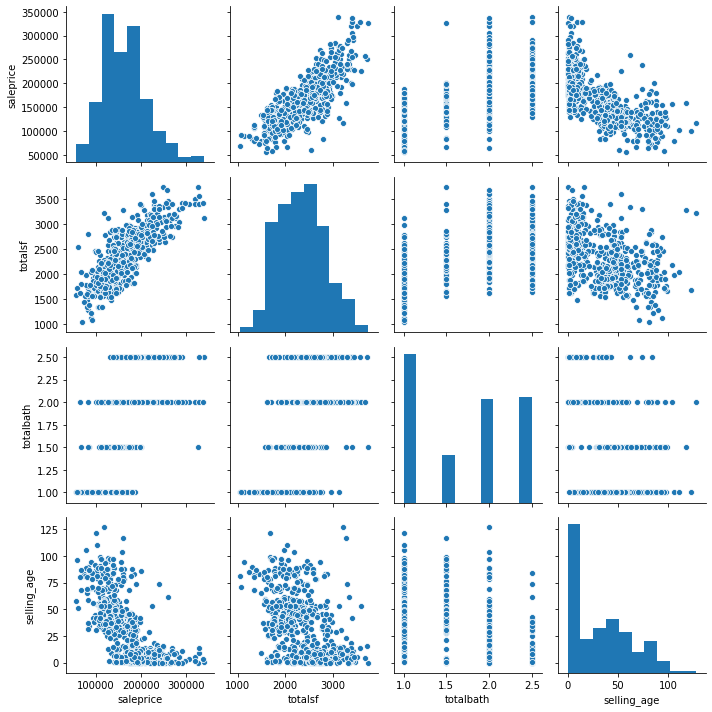

In [19]:
sns.pairplot(df[['saleprice','totalsf', 'totalbath', 'selling_age']])
plt.tight_layout()
plt.show()

It looks like the new variables above do have a relation to sales price, let's include them in the potential model. Also, note the potential relation between `selling_age` and `totalsf`.

In [20]:
data = pd.DataFrame()

Target variable.

In [21]:
data['target'] = df.saleprice.copy()

Continuous variables from `df`.

In [22]:
data['totalsf'] = df.totalsf.copy()
data['grlivarea'] = df.grlivarea.copy()
data['garagearea'] = df.garagearea.copy()
data['selling_age'] = df.selling_age.copy()

Now that all the continuous variables are together (along with the continuous target) it makes sense to scale these with the StandardScaler in order to get them all into like terms (in this case the terms of their variance).

In [23]:
scaler = StandardScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)

We'll also create indicator/dummy variables for categorical variables of interest. This list happens to be the highlights list from the prior section in addition to the new `totalbath` variable.

In [24]:
highlights = ['mssubclass', 'mszoning', 'housestyle', 'overallqual', 'exterqual', 'bsmtqual', 'kitchenqual', 'bedroomabvgr', 'totalbath']

In [25]:
temp = pd.get_dummies(df[highlights], drop_first=True).copy()

In [26]:
data = pd.concat([data, temp], axis=1).copy()

Now, we have a dataset in `data` containing the scaled target variable `saleprice` as well as all the (likely) useful features.

# 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

In [27]:
target = data.iloc[:, 0]
X_data = data.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=.2, random_state=12)

In [28]:
X_train.shape, X_test.shape

((507, 58), (127, 58))

# 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
# AND
# 5. Evaluate your best model on the test set.

Let's actually use LASSO regression to try and remove features with little impact on the outcome variable based on the training set while also trying to keep the model generalized.

In [29]:
lasso = LassoCV(cv=5)

sfm = SelectFromModel(lasso, max_features=15)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=None, normalize=False,
                                  positive=False, precompute='auto',
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=15, norm_order=1, prefit=False, threshold=None)

In [30]:
len(sfm.get_support()), sfm.get_support().sum()

(58, 15)

So, using the above method, it would appear LASSO has eliminated 72 of the 82 features in this model! Let's get those features and use only those and see the results.

In [31]:
selected_feat = X_train.columns[(sfm.get_support())]
selected_feat

Index(['totalsf', 'grlivarea', 'selling_age', 'mssubclass_160', 'mszoning_FV',
       'overallqual_7', 'overallqual_8', 'overallqual_9', 'exterqual_Fa',
       'bsmtqual_Gd', 'bsmtqual_TA', 'kitchenqual_Fa', 'kitchenqual_Gd',
       'kitchenqual_TA', 'bedroomabvgr_5'],
      dtype='object')

It appears that the above features are those which LASSO found to be most important. Let's see how well these do for our various models.

Let's redo the `train_test_split` with only our new features.

In [32]:
X_data = data[selected_feat]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=.2, random_state=12)

In [34]:
def do_it_all(model):
    model = model
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_test)
    
    print('-----{}-----'.format(str(type(model)).replace("'>", '').split('.')[-1]))     
    print("R-squared train: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print(f'R-squared test: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, y_preds)}')
    print(f'MSE: {mse(y_test, y_preds)}')
    print(f'RMSE: {rmse(y_test, y_preds)}')
    print(f'MAPE: {np.mean(np.abs((y_test - y_preds)/y_test))*100}')
    try:
        print('Coefficients: {}'.format(model.coef_))
        print('Intercept: {}'.format(model.intercept_))
        print('Alpha: {}'.format(model.alpha_))
        print('L1 Ratio: {}'.format(model.l1_ratio_))
    except:
        pass
    
    plt.scatter(y_test, y_preds)
    plt.plot(y_test, y_test, color='red')
    plt.xlabel('Actual (Scaled) House Prices')
    plt.ylabel('Predicted (Scaled) House Prices')
    plt.title('Predicted vs. Actual House Prices')
    plt.show()

-----LinearRegression-----
R-squared train: 0.8775662306043138
-----Test set statistics-----
R-squared test: 0.7397289633605335
MAE: 0.3376845038151995
MSE: 0.20803665623424702
RMSE: 0.4561103553245059
MAPE: 199.07410188661535
Coefficients: [ 0.25081763  0.27085552 -0.32943322 -0.5837698   0.27182734  0.24232881
  0.6746969   1.39503187 -0.74856055 -0.26913473 -0.24332827 -0.52607122
 -0.45860069 -0.5859856  -0.84581368]
Intercept: 0.6306975670746527


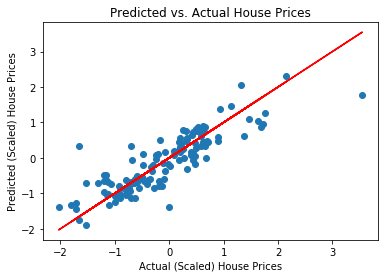

In [35]:
do_it_all(LinearRegression())

-----RidgeCV-----
R-squared train: 0.8762595483012929
-----Test set statistics-----
R-squared test: 0.7443458544544612
MAE: 0.3312240744745569
MSE: 0.20434633940998634
RMSE: 0.4520468332042448
MAPE: 198.75712007971504
Coefficients: [ 0.2688404   0.26223116 -0.33795371 -0.52655847  0.26079659  0.21986439
  0.63999469  1.13895029 -0.55759623 -0.29179006 -0.262148   -0.4758595
 -0.40681228 -0.53383999 -0.41939532]
Intercept: 0.60799368514094
Alpha: 1.0


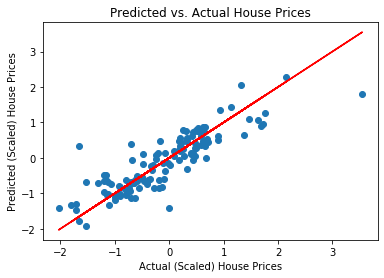

In [36]:
do_it_all(RidgeCV(cv=5))

-----LassoCV-----
R-squared train: 0.8767806696830053
-----Test set statistics-----
R-squared test: 0.7415537002944791
MAE: 0.33243289548290683
MSE: 0.2065781298644035
RMSE: 0.4545086686350476
MAPE: 198.05506082571384
Coefficients: [ 0.2589261   0.26541237 -0.33425964 -0.53578348  0.24877685  0.2319997
  0.67256012  1.3481309  -0.59573964 -0.25738574 -0.23256972 -0.45657406
 -0.38277656 -0.50802531 -0.3991478 ]
Intercept: 0.5473771896441091
Alpha: 0.0008475095256941161


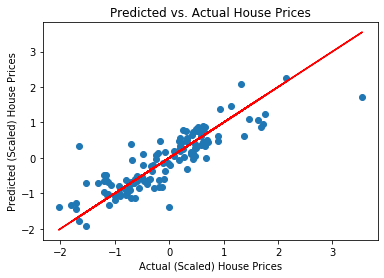

In [37]:
do_it_all(LassoCV(cv=5))

-----ElasticNetCV-----
R-squared train: 0.8759216685360478
-----Test set statistics-----
R-squared test: 0.7425398190772792
MAE: 0.3301230247471702
MSE: 0.2057899174806041
RMSE: 0.4536407361344483
MAPE: 197.96554634473176
Coefficients: [ 0.26733118  0.26180847 -0.33750572 -0.51145806  0.24526211  0.22095192
  0.65441103  1.224028   -0.52047171 -0.26845996 -0.24206353 -0.43677676
 -0.36632688 -0.49222976 -0.2824031 ]
Intercept: 0.5457036784089807
Alpha: 0.0016950190513882325
L1 Ratio: 0.5


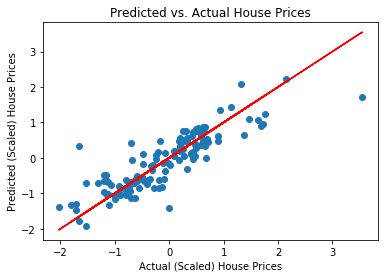

In [38]:
do_it_all(ElasticNetCV(cv=5))

Of the above, the Ridge regularization was the model that worked the best.

I wonder how it would perform under the original model I created way back at the beginning.

In [39]:
data = pd.DataFrame()
data['target'] = df['saleprice']
data[['totalsf', 'garagearea', 'selling_age']] = df[['totalsf', 'garagearea', 'selling_age']].copy()

In [40]:
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

In [41]:
target = data.iloc[:, 0]
X_data = data.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=.2, random_state=12)

In [42]:
X_train.shape, X_test.shape

((507, 3), (127, 3))

-----LinearRegression-----
R-squared train: 0.7886707952760887
-----Test set statistics-----
R-squared test: 0.6833159902392407
MAE: 0.3740763788204892
MSE: 0.2531279827526223
RMSE: 0.5031182592121084
MAPE: 200.08310868692666
Coefficients: [ 0.6005167   0.12686917 -0.34253672]
Intercept: 0.003151301939394502


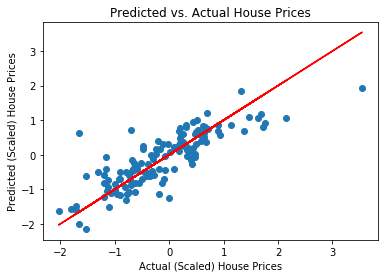

In [43]:
do_it_all(LinearRegression())

-----RidgeCV-----
R-squared train: 0.7886693646686812
-----Test set statistics-----
R-squared test: 0.6835401378303299
MAE: 0.37384722017467503
MSE: 0.25294881984631035
RMSE: 0.5029401752160095
MAPE: 199.8216440930307
Coefficients: [ 0.59935394  0.12730276 -0.34219499]
Intercept: 0.0031972756184255255
Alpha: 1.0


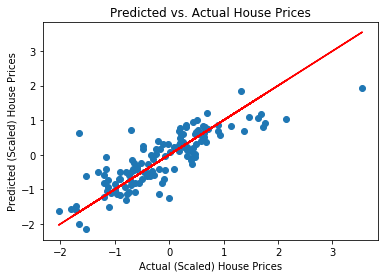

In [44]:
do_it_all(RidgeCV(cv=5))

-----LassoCV-----
R-squared train: 0.7886562107141957
-----Test set statistics-----
R-squared test: 0.6835488356620446
MAE: 0.37370725383520476
MSE: 0.25294186760202764
RMSE: 0.5029332635668748
MAPE: 199.3841375638348
Coefficients: [ 0.59882485  0.12529633 -0.34103012]
Intercept: 0.003234225483416661
Alpha: 0.0031908189598834785


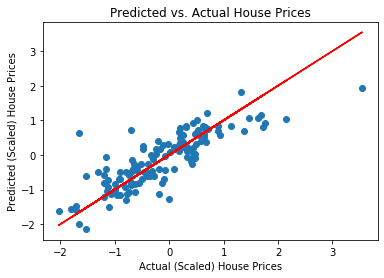

In [45]:
do_it_all(LassoCV(cv=5))

-----ElasticNetCV-----
R-squared train: 0.7886489950812181
-----Test set statistics-----
R-squared test: 0.6838254112451579
MAE: 0.3734556740047175
MSE: 0.2527207985954649
RMSE: 0.5027134358612916
MAPE: 199.1124125416743
Coefficients: [ 0.59741401  0.1261094  -0.34074816]
Intercept: 0.0032879208553828095
Alpha: 0.0055504232157851385
L1 Ratio: 0.5


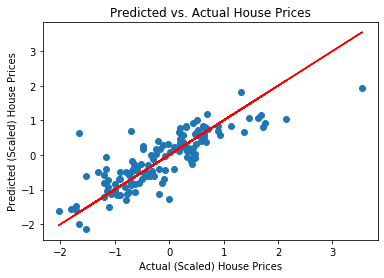

In [46]:
do_it_all(ElasticNetCV(cv=5))

# 6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

Interest rates and unemployment rates may have an impact on sale price. Let's look and see if they have anything to do with changes in price over the years.

In [47]:
ir_df = pd.read_csv('FEDFUNDS.csv')
ur_df = pd.read_csv('UNRATE.csv')
outside_df = ir_df.merge(ur_df, on='DATE').copy()

In [48]:
outside_df['yrsold'] = outside_df['DATE'].apply(lambda x: x.split('-')[0]).astype('int').copy()
outside_df['mosold'] = outside_df['DATE'].apply(lambda x: x.split('-')[1]).astype('int').copy()
outside_df.drop(columns='DATE', inplace=True)

In [49]:
df['mosold'] = df.mosold.astype('int').copy()
df['yrsold'] = df.yrsold.astype('int').copy()

In [50]:
df = df.merge(outside_df, on=['mosold','yrsold']).copy()

In [51]:
df.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,mosold,yrsold,saletype,salecondition,saleprice,totalsf,totalbath,selling_age,FEDFUNDS,UNRATE
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,2,2008,WD,Normal,208500,2566,2.5,5,2.98,4.9
1,20,RL,70.0,11200,Pave,None,Reg,Lvl,AllPub,Inside,...,2,2008,WD,Normal,129500,2080,1.0,43,2.98,4.9
2,20,RL,100.0,21750,Pave,None,Reg,HLS,AllPub,Inside,...,2,2008,WD,Normal,113000,1976,1.0,54,2.98,4.9
3,60,FV,75.0,9803,Pave,None,Reg,Lvl,AllPub,Inside,...,2,2008,WD,Normal,226700,2634,2.5,3,2.98,4.9
4,160,FV,34.0,3604,Pave,Pave,Reg,Lvl,AllPub,Corner,...,2,2008,WD,Abnorml,146000,2081,2.0,1,2.98,4.9


Now that the FEDFUNDS (interest rate) and UNRATE (unemployment rate) are in the dataframe we can redo our model from before and see if it does better with these other factors.

In [52]:
data = pd.DataFrame()
data['target'] = df.saleprice.copy()
data['totalsf'] = df.totalsf.copy()
data['grlivarea'] = df.grlivarea.copy()
data['garagearea'] = df.garagearea.copy()
data['selling_age'] = df.selling_age.copy()
data['int_rate'] = df.FEDFUNDS.copy()
data['unemp_rate'] = df.UNRATE.copy()

In [53]:
scaler = StandardScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)

In [54]:
highlights = ['mssubclass', 'mszoning', 'housestyle', 'overallqual', 'exterqual', 'bsmtqual', 'kitchenqual', 'bedroomabvgr', 'totalbath']
temp = pd.get_dummies(df[highlights], drop_first=True).copy()
data = pd.concat([data, temp], axis=1).copy()

In [55]:
target = data.iloc[:, 0]
X_data = data.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=.2, random_state=12)

See if the LASSO embedded feature selection chooses either of the two new factors.

In [56]:
lasso = LassoCV(cv=5)

sfm = SelectFromModel(lasso, max_features=28)
sfm.fit(X_train, y_train)

selected_feat = X_train.columns[(sfm.get_support())]
selected_feat

Index(['totalsf', 'grlivarea', 'garagearea', 'selling_age', 'unemp_rate',
       'mssubclass_50', 'mssubclass_160', 'mszoning_FV', 'mszoning_RL',
       'housestyle_1Story', 'overallqual_3', 'overallqual_4', 'overallqual_5',
       'overallqual_6', 'overallqual_8', 'overallqual_9', 'overallqual_10',
       'exterqual_Fa', 'bsmtqual_Fa', 'bsmtqual_Gd', 'bsmtqual_TA',
       'kitchenqual_Fa', 'kitchenqual_Gd', 'kitchenqual_TA', 'bedroomabvgr_2',
       'bedroomabvgr_3', 'bedroomabvgr_5', 'totalbath_2.5'],
      dtype='object')

In order for unemployment rate to be included, the number of significant features would have to be increased to 28 using the LASSO embedded method. This is in contrast to the 15 features the model was pared down to earlier. Doesn't hurt to test a few models with this feature set (it may overfit however). It may be because this is a national rate and may not reflect the exact unemployment rate in this sample's area.

In [57]:
X_data = data[selected_feat]
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=.2, random_state=12)

-----LinearRegression-----
R-squared train: 0.8900960297437126
-----Test set statistics-----
R-squared test: 0.7916346396901253
MAE: 0.3005589083027552
MSE: 0.1593165175401584
RMSE: 0.39914473257223176
MAPE: 193.3994722450714
Coefficients: [ 0.31525821  0.16026433  0.08460792 -0.19583775  0.02643995 -0.10453728
 -0.63650941  0.41381945  0.11170656 -0.1507108  -0.42974105 -0.33329196
 -0.17752046 -0.1784342   0.37750941  0.88469589  1.22084977 -0.73893903
 -0.5155899  -0.50591083 -0.6076196  -0.69949795 -0.41487703 -0.55238979
  0.11886111  0.07073236 -0.37606421  0.05319097]
Intercept: 1.0280888923510056


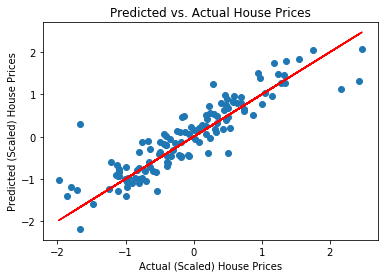

In [58]:
do_it_all(LinearRegression())

-----LassoCV-----
R-squared train: 0.8889498335609913
-----Test set statistics-----
R-squared test: 0.7929054005425498
MAE: 0.29953574191715576
MSE: 0.1583448915782733
RMSE: 0.3979257362602642
MAPE: 169.37343606246543
Coefficients: [ 0.32788679  0.15288688  0.08857306 -0.21203393  0.02822999 -0.08055122
 -0.58943362  0.3819056   0.10322078 -0.14577444 -0.29132052 -0.31013932
 -0.15465874 -0.16388866  0.37606315  0.82171215  0.83092545 -0.55583252
 -0.43726006 -0.47545119 -0.57319381 -0.6484571  -0.38013044 -0.51572125
  0.1006029   0.05721558 -0.15525868  0.04976082]
Intercept: 0.9638738060468763
Alpha: 0.0008353547898633826


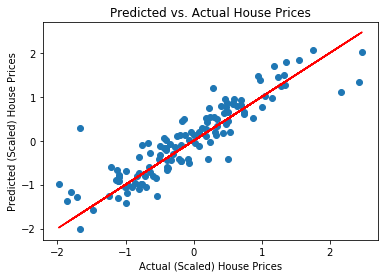

In [59]:
do_it_all(LassoCV(cv=5))

-----RidgeCV-----
R-squared train: 0.8885088640045302
-----Test set statistics-----
R-squared test: 0.7916306057083762
MAE: 0.30053062774124606
MSE: 0.1593196019296325
RMSE: 0.3991485963017188
MAPE: 168.20086977790947
Coefficients: [ 0.3353413   0.14879007  0.08864235 -0.2098332   0.0289849  -0.09329867
 -0.57733146  0.38621417  0.10974104 -0.15230172 -0.32962435 -0.32796001
 -0.17232802 -0.17683087  0.36506353  0.71473916  0.60973635 -0.51631744
 -0.44440863 -0.49128936 -0.57776217 -0.62508825 -0.3885623  -0.51653223
  0.11921116  0.0715828  -0.25110813  0.05355374]
Intercept: 0.9734756555406378
Alpha: 1.0


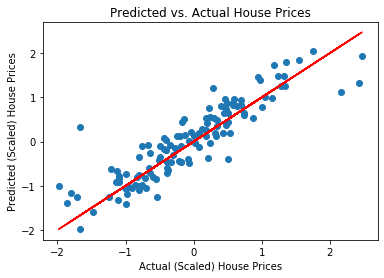

In [60]:
do_it_all(RidgeCV(cv=5))

-----ElasticNetCV-----
R-squared train: 0.887738902732541
-----Test set statistics-----
R-squared test: 0.7924127186014265
MAE: 0.2997095443634728
MSE: 0.15872159704888497
RMSE: 0.39839879147518126
MAPE: 159.11827333650191
Coefficients: [ 0.33625925  0.14840738  0.09010301 -0.21736403  0.02917505 -0.07666782
 -0.56514103  0.37042357  0.10197926 -0.14610042 -0.25822719 -0.30893791
 -0.15338403 -0.16358918  0.36965904  0.74312801  0.5811454  -0.47178898
 -0.41096354 -0.47169718 -0.5627619  -0.61588017 -0.37011471 -0.50178769
  0.10076639  0.05721754 -0.13148709  0.05021099]
Intercept: 0.9452993337903891
Alpha: 0.0016707095797267653
L1 Ratio: 0.5


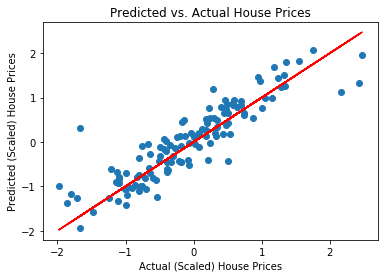

In [61]:
do_it_all(ElasticNetCV(cv=5))

It actually appears that all the above models perform much better than any prior model for any of these regression methods, it is likely because of the large amount of features kept from the dataset (thus more variation of the outcome variable can be explained). The drawback may be that this may not work as well for houses in another area because this sample is from a particular city. However, it would appear that these factors are useful in predicting house prices in this particular area.

# Quick Summary

Ultimately picking one of the above models to use depends on the context of the data we are trying to predict, it would also be useful to consistently test how the model or models do when provided with new data. If estimating prices in this particular location alone, then more features may be relevant (for example including neighborhood data, which I have removed for generalization). Say you wanted to estimate the price for any given house in the US. The more general the model, the better it would likely perform. But if you had neighborhood house price data for say, the entire US, then it would likely be relevant to include that information in the model as it would likely help with accurate predicitons (similar houses in the same neighborhood often share similar prices). It all depends on the ultimate goal.

For this particular problem, I would likely continue to use each model concurrently and see how they performed over time. If one model proved to be better than the others then I would likely adopt that one and continue to monitor its progress (and if able, continue to run the other models as well). As for the use of unemployment rates and interest rates, it may be more useful to obtain and use more localized data if it were available. The national unemployment rate, which is really a linear combination of all the unemployment rates over the entire nation (by state, by city, by neighborhood), likely contains information about this given area, but only a very small part of it. This area may not be a good sample for the entire US when it comes to unemployment rate - therefore, it appears to have low predictive power when taken from a macro estimator to a micro predictor.